In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
import os
import requests
import shutil
import random
from PIL import Image

device = "cuda" if torch.cuda.is_available() else 'cpu'

## Download Dataset

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install opendatasets

In [7]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")


100%|██████████| 331M/331M [00:07<00:00, 44.6MB/s]


# Preparation Dataset

In [8]:
past_folder = '/content/utkface-new/UTKFace'
new_folder = '/content/dataset'

train_ann_path = '/content/train_ann.txt'
test_ann_path = '/content/test_ann.txt'

if not os.path.exists(new_folder):
    os.mkdir(new_folder)

train_folder = os.path.join(new_folder, 'train')
test_folder = os.path.join(new_folder, 'test')
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
if not os.path.exists(test_folder):
    os.mkdir(test_folder)

train_cnt = 0
test_cnt = 0
with open(train_ann_path, 'w') as train_ann, open(test_ann_path, 'w') as test_ann:
    for filename in os.listdir(past_folder):
        file_path = os.path.join(past_folder, filename)
        mask = random.choices([0, 1], weights=[0.1, 0.9], k=1)[0]
        prefix = filename.split('_')
        if len(prefix) != 4:
            continue
        if mask:
            train_cnt += 1
            filename = str(train_cnt) + '.jpg'
            destination_path = os.path.join(train_folder, filename)
            shutil.copy(file_path, destination_path)
            age = int(prefix[0])
            age = age - (age % 10)
            prefix[0] = str(int(age/10))
            train_ann.write('|'.join(prefix) + '\n')
        else:
            test_cnt += 1
            filename = str(test_cnt) + '.jpg'
            destination_path = os.path.join(test_folder, filename)
            shutil.copy(file_path, destination_path)
            age = int(prefix[0])
            age = age - (age % 10)
            prefix[0] = str(int(age/10))
            test_ann.write('|'.join(prefix) + '\n')


# Create Dataset

In [9]:
class UTKface(Dataset):
    def __init__(self, images_path, ann_path, phase, transform=None):
        self.images_path = images_path
        self.ann_path = ann_path
        self.transform = transform
        self.phase = phase

    def __getitem__(self, idx):
        idx += 1
        image_path = os.path.join(self.images_path, str(idx) + ".jpg")
        image = Image.open(image_path).convert('RGB')
        if transform != None:
            image = self.transform(image)

        with open(self.ann_path, 'r') as file:
            lines = file.readlines()
            label = int(lines[idx - 1].split("|")[self.phase])
        data = {"image":image, "label":label}
        return data
    def __len__(self):
        return len(os.listdir(self.images_path))


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5957, 0.4559, 0.3901), (0.2184, 0.1944, 0.1852))
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize((0.6360, 0.4871, 0.4185), (0.2108, 0.1894, 0.1820))
])

In [11]:
TrainSet_age = UTKface("/content/dataset/train", "/content/train_ann.txt", 0, train_transform)
TrainSet_gender = UTKface("/content/dataset/train", "/content/train_ann.txt", 1, train_transform)
TrainSet_race = UTKface("/content/dataset/train", "/content/train_ann.txt", 2, train_transform)
TestSet_age = UTKface("/content/dataset/test", "/content/test_ann.txt", 0, test_transform)
TestSet_gender = UTKface("/content/dataset/test", "/content/test_ann.txt", 1, test_transform)
TestSet_race = UTKface("/content/dataset/test", "/content/test_ann.txt", 2, test_transform)

In [12]:
TrainLoader_age = torch.utils.data.DataLoader(TrainSet_age,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_age = torch.utils.data.DataLoader(TestSet_age,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_gender = torch.utils.data.DataLoader(TrainSet_gender,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_gender = torch.utils.data.DataLoader(TestSet_gender,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_race = torch.utils.data.DataLoader(TrainSet_race,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_race = torch.utils.data.DataLoader(TestSet_race,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

In [13]:
next(iter(TrainLoader_age))

{'image': tensor([[[[-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           ...,
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276]],
 
          [[-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           ...,
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452]],
 
          [[-2.1064, -2.1064, -2.1064,  ..., -2.1064, -2.1064, -2.1064],
    

# Plot Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def plot_batch(batch):
    images = batch["image"]
    labels = batch["label"]

    batch_size = images.size(0)
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).numpy()
        label = int(labels[i].item())

        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(image)
        ax.set_title(f"Age: [{label * 10}, {label * 10 + 10}]")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


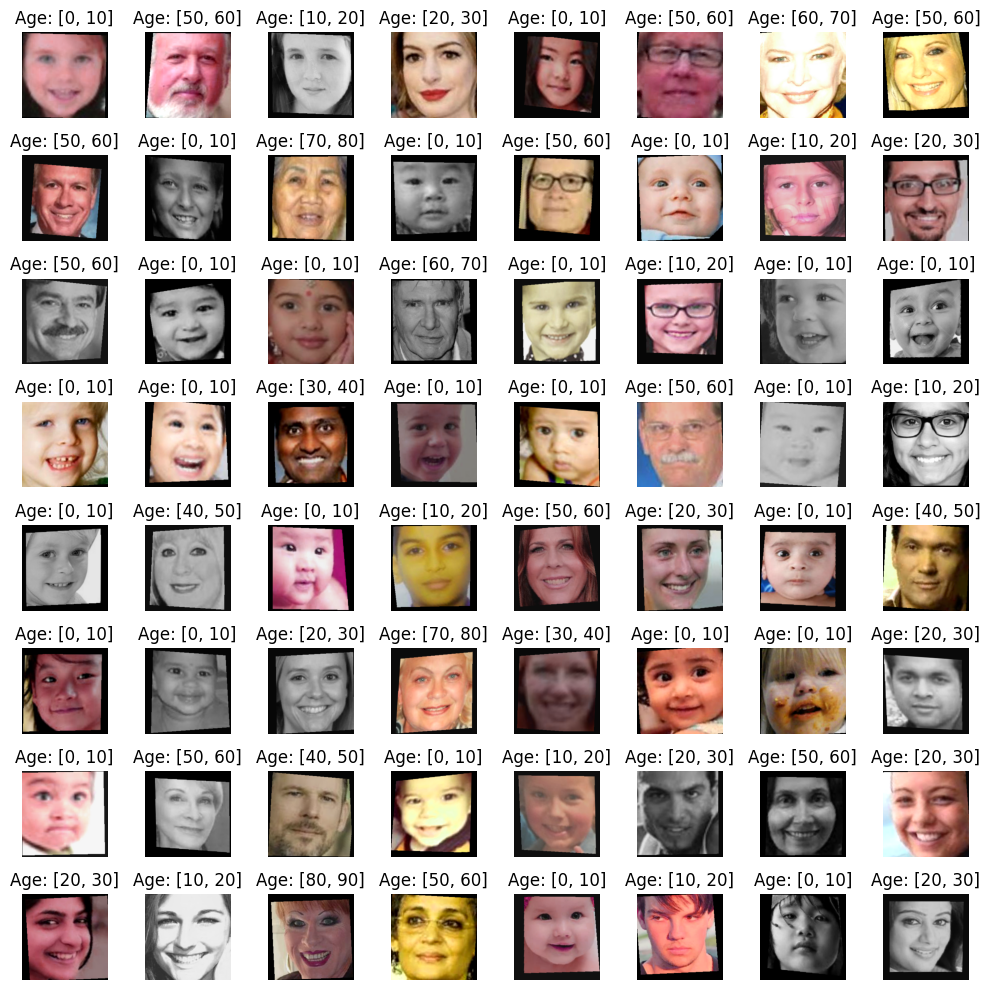

In [ ]:
batch = next(iter(TrainLoader_age))
plot_batch(batch)

# Create Model

In [14]:
from torch.nn.modules.linear import Linear
model = torchvision.models.efficientnet_b5(True)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features=2048, out_features=12, bias=True))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 136MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [15]:
model = model.to(device)

# Loss Function and Optimizer

In [16]:
import torch.optim as optim

criterion = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train/Test Function

In [17]:
def Train(epoch, dataloader):
    running_loss = 0.0
    iter_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        # backward + optimize
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        iter_loss += loss.item()

        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'{i + 1:5d} ===> loss: {iter_loss / 500}')
            iter_loss = 0.0

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Train loss ---------> {running_loss / i}')
    print(f'Train accuracy -----> {accuracy}')
    running_loss = 0.0

In [18]:
def Test(dataloader):
    running_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        #loss
        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Test loss ---------> {running_loss / i}')
    print(f'Test accuracy -----> {accuracy}')
    running_loss = 0.0

# Train

In [19]:
epochs = 10
train_loader = TrainLoader_age
test_loader = TestLoader_age

In [20]:
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}:')
    Train(epoch, train_loader)
    Test(test_loader)
    torch.save(model, f'/content/saves/age_estimation{epoch + 1}.pth')
print('Finished Training')

Epoch 1:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  500 ===> loss: 1.5742347886934875
 1000 ===> loss: 1.4748534593805671
 1500 ===> loss: 1.2125763946175576
 2000 ===> loss: 1.0950658721327782
 2500 ===> loss: 1.0388173126131297
 3000 ===> loss: 0.9935053539499641
 3500 ===> loss: 0.8704340953975916
 4000 ===> loss: 0.8744275069534778
 4500 ===> loss: 0.9234377414919436
 5000 ===> loss: 0.8182330885231495
 5500 ===> loss: 0.8318947283066809
 6000 ===> loss: 0.8346575034037232
 6500 ===> loss: 0.8285752501562238
 7000 ===> loss: 0.7658161239102482
 7500 ===> loss: 0.7911274471152574
 8000 ===> loss: 0.6901752661447972
 8500 ===> loss: 0.8013983266651631
 9000 ===> loss: 0.7825279141068459
 9500 ===> loss: 0.7559683290533722
10000 ===> loss: 0.8094324037134647
10500 ===> loss: 0.7329220257662237
11000 ===> loss: 0.7291504434645176
11500 ===> loss: 0.7612128307409585
12000 ===> loss: 0.7617704301178455
12500 ===> loss: 0.7502817754782737
13000 ===> loss: 0.7061372432298958
13500 ===> loss: 0.7393971629235894
14000 ===> loss: 0.740241141

# Check wrong answers

In [ ]:
false_estimates = []
for i in range(1965):
  if i % 500 == 0:
    print(i)
  data = TestSet_age[i]
  input, label = data["image"], data["label"]
  input = input.unsqueeze(dim=0)
  model.to('cpu')
  out = model(input)
  _, predicted_labels = torch.max(out, 1)
  if predicted_labels.item() != label:
    false_estimates.append((input, label, predicted_labels.item()))
    if len(false_estimates) >= 64:
      break
print(len(false_estimates))

0
64


64


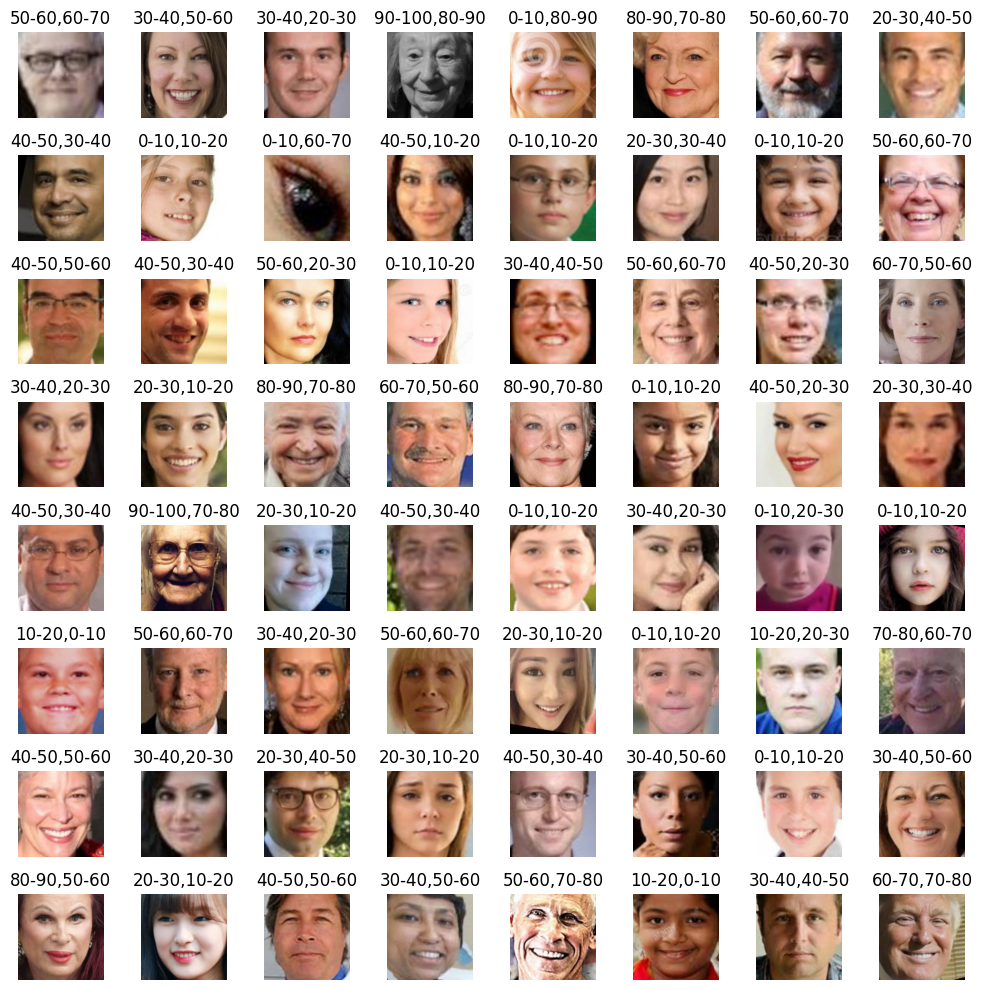

In [ ]:
batch_size = 64

grid_size = int(np.ceil(np.sqrt(batch_size)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

print(len(false_estimates))

for i in range(batch_size):
    image = false_estimates[i][0][0].permute(1, 2, 0).numpy()
    label = false_estimates[i][1]
    out_label = false_estimates[i][2]

    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(image)
    ax.set_title(f"{label*10}-{label*10+10},{out_label*10}-{out_label*10+10}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# More Information
Training time: 5h 36m 39s

10 Epochs

Train loss ---------> 0.48835498875854333

Test loss ---------> 0.548615121322033